<a href="https://colab.research.google.com/github/MuhammedAshraf2020/NLP-Pytorch/blob/main/Sentiment_Classification_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get IMDB Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 51% 13.0M/25.7M [00:00<00:00, 47.1MB/s]
100% 25.7M/25.7M [00:00<00:00, 85.6MB/s]


In [4]:
!unzip /content/imdb-dataset-of-50k-movie-reviews.zip

Archive:  /content/imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [113]:
data = pd.read_csv("/content/IMDB Dataset.csv")

In [6]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
sizes = data.groupby("sentiment").size()

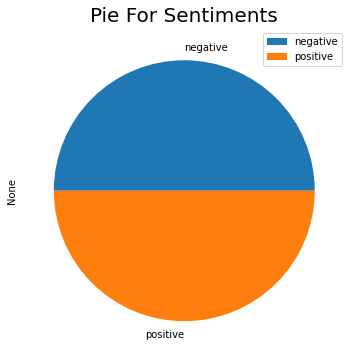

In [8]:
sizes.plot(kind = "pie" , subplots = True , figsize = (8 , 6))
plt.title("Pie For Sentiments" , fontsize = 20)
plt.legend()
plt.show()

In [119]:
#lets devide data into train test files :)
datalen = len(data)
train_size = int(datalen * 0.8)
data_train = data.iloc[0:train_size ]
data_test  = data.iloc[train_size : ]
data_train.to_csv("train.csv" , index = False )
data_test.to_csv("test.csv" , index = False )

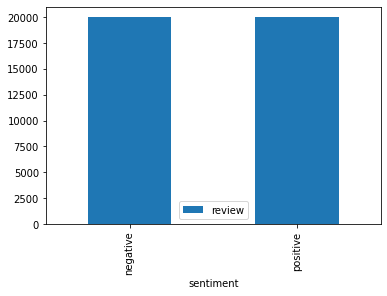

In [115]:
#lets check our train data is not bised
df_train = pd.read_csv("train.csv")
df_train.groupby("sentiment").count().plot.bar(ylim = 0)

# Custom Data

In [11]:
import torch
import spacy
from torch.utils.data import Dataset , DataLoader
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [81]:
import spacy
import string
nlp = spacy.load("en_core_web_sm")

In [13]:
def lemma(txt):
  return nlp(txt)[:].lemma_

In [14]:
def numurize(sent):
  if sent == "positive":
    return 1
  else:
    return 0

In [83]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

In [117]:
class Sequances(Dataset):
  def __init__(self , path):
    super().__init__()
    data = pd.read_csv(path)
    # lets remove tage , seprate don't and 
    data["review"] = data["review"].str.replace("<.*?>" , "")
    data["review"] = data["review"].str.replace("n't"   , " not" )
    data["review"] = data["review"].str.replace('[{}]'.format(string.punctuation), ' ')
    data["review"] = data["review"].apply(lambda x : " ".join([word for word in x.split() 
                                                                if word not in stopwords]))
    data["review"] = data["review"].apply(lambda x : lemma(x))

    data["sentiment"] = data["sentiment"].apply(lambda x : numurize(x))

    reviews = data["review"].tolist()
    self.labels  = data["sentiment"].tolist()

    self.tokenizer = Tokenizer(num_words = 400)
    self.tokenizer.fit_on_texts(reviews)
    self.worddict = self.tokenizer.word_index

    sequences = self.tokenizer.texts_to_sequences(reviews)
    self.sequences = pad_sequences(sequences , maxlen = 200 , padding = "post" )
  
  def __len__(self):
    return len(self.sequences)
  
  def __getitem__(self , i):
    return self.sequences[i , :] , self.labels[i]

In [118]:
class TestSequances(Dataset):
  def __init__(self , path , tokenize):
    super().__init__()
    data = pd.read_csv(path)
    # lets remove tage , seprate don't and 
    data["review"] = data["review"].str.replace("<.*?>" , "")
    data["review"] = data["review"].str.replace("n't"   , " not" )
    data["review"] = data["review"].str.replace('[{}]'.format(string.punctuation), ' ')
    data["review"] = data["review"].apply(lambda x : " ".join([word for word in x.split() 
                                                                if word not in stopwords]))
    data["review"] = data["review"].apply(lambda x : lemma(x))

    data["sentiment"] = data["sentiment"].apply(lambda x : numurize(x))

    reviews = data["review"].tolist()
    self.labels  = data["sentiment"].tolist()

    self.tokenize = tokenize
    sequences = self.tokenize.texts_to_sequences(reviews)
    self.sequences = pad_sequences(sequences , maxlen = 200 , padding = "post" )
  
  def __len__(self):
    return len(self.sequences)
  
  def __getitem__(self , i):
    return self.sequences[i , :] , self.labels[i]

In [120]:
#lets build Train / Val / Test DataLoader

trainSequances = Sequances("/content/train.csv")
trainLoader = DataLoader(trainSequances , shuffle = True , batch_size = 1200)

testSequances = TestSequances("/content/test.csv" , trainSequances.tokenizer)
testLoader = DataLoader(testSequances , shuffle = True , batch_size = 1200)

# Embedding (GloVe)

In [17]:
!kaggle datasets download -d watts2/glove6b50dtxt

 81% 55.0M/67.7M [00:00<00:00, 70.7MB/s]
100% 67.7M/67.7M [00:00<00:00, 105MB/s] 


In [18]:
!unzip /content/glove6b50dtxt.zip

Archive:  /content/glove6b50dtxt.zip
  inflating: glove.6B.50d.txt        


In [19]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
  return word_to_vec_map

In [20]:
word_to_vec_map = read_glove_vector('/content/glove.6B.50d.txt')

In [121]:
vocuablary_len = len(trainSequances.worddict)
embeded_len = word_to_vec_map["love"].shape[0]
max_len = 150

print("Number of Words =", vocuablary_len)
#print("Number of Reviews =" , datalen - 100)
print("Length of Embeded Vector =" , embeded_len )
print("Max Length of Words In a Review =" , max_len)

Number of Words = 85199
Length of Embeded Vector = 50
Max Length of Words In a Review = 150


In [122]:
embed_matrix = np.zeros((vocuablary_len , embeded_len))

for word , index in trainSequances.worddict.items():
  embed_vect = word_to_vec_map.get(word)
  if embed_vect is not None:
    embed_matrix[index -1 , :] = embed_vect

In [23]:
embed_matrix[1]

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01])

# Build LSTM Model

In [24]:
import torch.nn as nn
import torch.optim as optim
import torch.functional as F

In [123]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': torch.Tensor(weights_matrix)})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

In [124]:
class Model(nn.Module):
  def __init__(self , embed_matrix , hidden_nerouns = 128 ,
               n_layers = 2 , trainable = False):
    
    super().__init__()
    self.hidden_nerouns = hidden_nerouns
    self.n_layers = n_layers

    self.embedding , vocab_lens , embedd_dim = create_emb_layer(embed_matrix , False)
    self.lstm = nn.LSTM(embedd_dim , hidden_nerouns , num_layers = n_layers , batch_first = True)
    self.linear = nn.Linear(128 , 1)
    self.dropout = nn.Dropout(0.65)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self , x):
    # x with shape of (batch , 300 , 85582)
    batch_size = x.size(0)
    x = self.embedding(x) # batch , 300 , 50
    hidden = self.init_hidden(x.size(0))
    lstm_out , lstm_hidden = self.lstm(x , hidden) # batch , 300 , 128
    out = self.dropout(lstm_out[: , -1 , :])
    out = self.linear(out)

    return self.sigmoid(out).squeeze()
  
  def init_hidden(self , batch_size):
    h0 = torch.randn(self.n_layers , batch_size , self.hidden_nerouns).to("cuda") # 2 , batch , 128
    c0 = torch.randn(self.n_layers , batch_size , self.hidden_nerouns).to("cuda") # 2 , batch , 128
    return (h0 , c0)


In [125]:
rnn = Model(embed_matrix).to("cuda")

In [92]:
rnn

Model(
  (embedding): Embedding(95319, 50)
  (lstm): LSTM(50, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.65, inplace=False)
  (sigmoid): Sigmoid()
)

In [126]:
loss = nn.BCELoss() 
opt  = optim.Adam(rnn.parameters())

# Model Train

In [30]:
from tqdm.notebook import tqdm

In [31]:
def get_acc(pred , y):
  pred = torch.round(pred)
  return torch.sum(pred == y).item() / len(pred)

In [75]:
def train(model ,  opt , loss , device = "cpu"):
  loop = tqdm(trainLoader , leave = False)
  total    = 0
  losses   = []
  accuracy = [] 

  for x , y in loop:

    model.zero_grad()
    x = x.to(device)
    y = y.to(device).float()

    predictions  = model(x)
    batch_loss = loss(predictions , y)

    batch_acc = get_acc(predictions , y)

    
    loop.set_description(f"loss : {batch_loss.item():.3f}")
    nn.utils.clip_grad_norm_(model.parameters(), 3)
    
    batch_loss.backward()
    opt.step()
    
    total += 1
    losses.append(batch_loss.item())
    accuracy.append(batch_acc)

  
  total_loss = sum(losses) / total
  total_acc  = (sum(accuracy) / total) * 100

  return total_loss , total_acc


In [129]:
rnn.train()
epochs_losses = []
epochs = 10
for epoch in range(epochs):
  lss , acc = train(rnn  , opt , loss , "cuda")
  print(f"Epoch [{epoch + 1} : {epochs}] Train Loss = {lss:.3f} , Train Accuracy = {acc:.3f} ")

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [1 : 10] Train Loss = 0.355 , Train Accuracy = 84.551 


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [2 : 10] Train Loss = 0.352 , Train Accuracy = 84.608 


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [3 : 10] Train Loss = 0.349 , Train Accuracy = 84.620 


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [4 : 10] Train Loss = 0.351 , Train Accuracy = 84.542 


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [5 : 10] Train Loss = 0.344 , Train Accuracy = 85.047 


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [6 : 10] Train Loss = 0.344 , Train Accuracy = 84.902 


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [7 : 10] Train Loss = 0.344 , Train Accuracy = 85.032 


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [8 : 10] Train Loss = 0.338 , Train Accuracy = 85.279 


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [9 : 10] Train Loss = 0.334 , Train Accuracy = 85.424 


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [10 : 10] Train Loss = 0.330 , Train Accuracy = 85.527 


In [34]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [41]:
def predict_sentiment(text):
    rnn.eval()
    with torch.no_grad():
        test_vector = torch.LongTensor([dataset.pad(dataset.encode(text))]).to(device)
        
        prediction = rnn(test_vector).item()
        if prediction > 0.5:
            print(f'{prediction:0.3}: Positive sentiment')
        else:
            print(f'{prediction:0.3}: Negative sentiment')

In [77]:
def model_evaluate(test_loader , loss):
  rnn.eval()
  test_loss = []
  test_acc  = []
  total = 0
  test_loop = tqdm(test_loader , leave = False)
  with torch.no_grad():
    for batch , target in test_loop:
      batch  = batch.to("cuda")
      target = target.to("cuda").float()

      predictions = rnn(batch) 
      batch_loss  = loss(predictions , target).item()
      batch_acc   = get_acc(predictions , target)

      test_loss.append(batch_loss)
      test_acc.append(batch_acc)
      total+=1
      test_loop.set_description(f" loss : {batch_loss:.3f}")
    
    total_loss = sum(test_loss) / total
    total_acc  = (sum(test_acc) / total) * 100.0
    
    print(f"Test Loss = {total_loss:.3f} , Train Accuracy = {total_acc:.3f} ")

  return (test_loss , test_acc)
    

In [131]:
hist = model_evaluate(testLoader , loss)

  0%|          | 0/9 [00:00<?, ?it/s]

Test Loss = 0.346 , Train Accuracy = 84.944 
